<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Getting-the-Raw-Data" data-toc-modified-id="Getting-the-Raw-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting the Raw Data</a></span></li><li><span><a href="#Method" data-toc-modified-id="Method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method</a></span><ul class="toc-item"><li><span><a href="#Participants" data-toc-modified-id="Participants-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Participants</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#How-are-students’-confidence-ratings-related-to-their-mean-facility,-age,-gender,-socioeconomic-disadvantage-and-mathematical-topic?" data-toc-modified-id="How-are-students’-confidence-ratings-related-to-their-mean-facility,-age,-gender,-socioeconomic-disadvantage-and-mathematical-topic?-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>How are students’ confidence ratings related to their mean facility, age, gender, socioeconomic disadvantage and mathematical topic?</a></span><ul class="toc-item"><li><span><a href="#Facility" data-toc-modified-id="Facility-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Facility</a></span></li></ul></li></ul></li></ul></div>

In [ ]:
import math
import pandas as pd
import numpy as np

import IPython
from IPython.display import IFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from scipy import stats
from statannot import add_stat_annotation

In [ ]:
from utils import apaStyleCorrelation, apaStylePValue, apaStyleCombined, apaStyleStatistic, set_style, export_fig, conf_dualplot, mann_whitney_rank_biserial_correlation, wilcoxon_signed_matched_pairs_rank_biserial_correlation, students_describe, students_kruskal, students_mann_whitney

In [ ]:
%matplotlib inline

# Dimensions taken from Educational Studies in Mathematics Guidelines https://bit.ly/38eECzS
width_inches_one_column = 84 / 25.4
width_inches_full_page = 174 / 25.4

# Additional setting for publication are set in the custom matplotlibrc file
set_style()

# Introduction

Code to reproduce the statistics and graphics in the paper "School students' confidence when answering diagnostic questions online".

# Getting the Raw Data

In [4]:
answers_raw = pd.read_csv("input/answers_with_confidence.csv", 
    dtype = { 
        "AnswerId": "int64",
        "UserId": "int64",
        "QuestionId": "int64",
        "Confidence": "int64",
        "DateAnswered": "object",
        "IsCorrect": "int64",
        "QuizBAnswerId": "float64",
        "QuizBQuestionId": "float64",
        "QuizBConfidence": "float64",
        "QuizBDateAnswered": "object",
        "QuizBIsCorrect": "float64"
    },
    parse_dates= [
        "DateAnswered",
        "QuizBDateAnswered"
    ])

answers_raw.set_index("AnswerId", inplace=True);

answers_raw["AnswerId"] = answers_raw.index;

In [5]:
students_metadata = pd.read_csv("input/students_with_confidence.csv", index_col="UserId")

gender_enum = { 0: "unspecified", 1: "female", 2: "male", 3: "other" }

students_metadata["Gender"] = students_metadata["Gender"].map(gender_enum)

In [6]:
students_metadata["age_group_sept_2018"] = None

students_metadata.loc[students_metadata["AgeSept2018"].isin([5,6]),"age_group_sept_2018"] = "5-6"
students_metadata.loc[students_metadata["AgeSept2018"].isin([7,8,9,10]),"age_group_sept_2018"] = "7-10"
students_metadata.loc[students_metadata["AgeSept2018"].isin([11,12,13]),"age_group_sept_2018"] = "11-13"
students_metadata.loc[students_metadata["AgeSept2018"].isin([14,15,16]),"age_group_sept_2018"] = "14-16"

In [7]:
students_metadata["AgeSept2019"] = students_metadata["AgeSept2018"] + 1 
students_metadata["age_group_sept_2019"] = None

students_metadata.loc[students_metadata["AgeSept2019"].isin([5,6]),"age_group_sept_2019"] = "5-6"
students_metadata.loc[students_metadata["AgeSept2019"].isin([7,8,9,10]),"age_group_sept_2019"] = "7-10"
students_metadata.loc[students_metadata["AgeSept2019"].isin([11,12,13]),"age_group_sept_2019"] = "11-13"
students_metadata.loc[students_metadata["AgeSept2019"].isin([14,15,16]),"age_group_sept_2019"] = "14-16"

In [8]:
students = answers_raw.groupby("UserId").agg( 
    AnswersCount = ("AnswerId", "count"),    
    MeanConfidence = ("Confidence", "mean"),
    StdConfidence = ("Confidence", np.std),
    CorrectCount = ("IsCorrect", lambda x: sum(x == 1))
)

students["IncorrectCount"] = students["AnswersCount"] - students["CorrectCount"]

students["Facility"] = 100 * students["CorrectCount"] / students["AnswersCount"]

In [9]:
students_confidence = answers_raw.groupby(["UserId", "IsCorrect"]).agg(
    MeanConfidence=("Confidence", np.mean)
).unstack().rename(columns = {
    0: "MeanConfidenceIncorrectAnswers", 
    1: "MeanConfidenceCorrectAnswers"
}, level = 1)

students_confidence.columns = students_confidence.columns.droplevel(0)

students_confidence["ConfidenceDifference"] = students_confidence["MeanConfidenceCorrectAnswers"] \
    - students_confidence["MeanConfidenceIncorrectAnswers"]

students = pd.merge(students, students_confidence, left_on="UserId", right_index=True, how="inner")

In [10]:
students = pd.merge(students, students_metadata, left_on="UserId", right_index=True, how="inner") 

In [11]:
students.head()

,AnswersCount,MeanConfidence,StdConfidence,CorrectCount,IncorrectCount,Facility,MeanConfidenceIncorrectAnswers,MeanConfidenceCorrectAnswers,ConfidenceDifference,Gender,AgeSept2018,IsAdvantaged,age_group_sept_2018,AgeSept2019,age_group_sept_2019
UserId,,,,,,,,,,,,,,,
4,16,81.25,34.761089,11,5,68.750000,75.0,84.090909,9.090909,female,14,1,14-16,15,14-16
14,6,100.00,0.000000,2,4,33.333333,100.0,100.000000,0.000000,male,12,1,11-13,13,11-13
23,8,12.50,35.355339,3,5,37.500000,0.0,33.333333,33.333333,male,14,1,14-16,15,14-16
39,18,100.00,0.000000,18,0,100.000000,NaN,100.000000,NaN,female,12,1,11-13,13,11-13
40,10,40.00,33.747428,7,3,70.000000,50.0,35.714286,-14.285714,female,12,0,11-13,13,11-13


In [12]:
answers = pd.merge(answers_raw, students, left_on="UserId", right_index=True, how="inner")

In [13]:
answers.head()

,UserId,QuestionId,Confidence,DateAnswered,IsCorrect,QuizBAnswerId,QuizBQuestionId,QuizBConfidence,QuizBDateAnswered,QuizBIsCorrect,...,Facility,MeanConfidenceIncorrectAnswers,MeanConfidenceCorrectAnswers,ConfidenceDifference,Gender,AgeSept2018,IsAdvantaged,age_group_sept_2018,AgeSept2019,age_group_sept_2019
AnswerId,,,,,,,,,,,,,,,,,,,,,
109404,6439,9892,0,2019-03-07 00:30:51.877,0,NaN,NaN,NaN,NaT,NaN,...,20.0,34.375,75.0,40.625,female,14,1,14-16,15,14-16
109405,6439,9893,75,2019-03-07 00:31:00.120,0,NaN,NaN,NaN,NaT,NaN,...,20.0,34.375,75.0,40.625,female,14,1,14-16,15,14-16
109395,6439,9882,50,2019-03-07 00:28:38.703,0,NaN,NaN,NaN,NaT,NaN,...,20.0,34.375,75.0,40.625,female,14,1,14-16,15,14-16
109396,6439,9884,25,2019-03-07 00:29:00.500,0,NaN,NaN,NaN,NaT,NaN,...,20.0,34.375,75.0,40.625,female,14,1,14-16,15,14-16
109400,6439,9887,0,2019-03-07 00:29:51.483,0,NaN,NaN,NaN,NaT,NaN,...,20.0,34.375,75.0,40.625,female,14,1,14-16,15,14-16


In [14]:
questions = answers_raw.groupby("QuestionId").agg( 
    AnswersCount = ("AnswerId", "count"),    
    MeanConfidence = ("Confidence", "mean"),
    StdConfidence = ("Confidence", np.std),
    CorrectCount = ("IsCorrect", lambda x: sum(x == 1))
)

questions["IncorrectCount"] = questions["AnswersCount"] - questions["CorrectCount"]

questions["Facility"] = 100 * questions["CorrectCount"] / questions["AnswersCount"]

In [15]:
questions_confidence = answers_raw.groupby(["QuestionId", "IsCorrect"]).agg(
    MeanConfidence=("Confidence", np.mean)
).unstack().rename(columns = {
    0: "MeanConfidenceIncorrectAnswers", 
    1: "MeanConfidenceCorrectAnswers"
}, level = 1)

questions_confidence.columns = questions_confidence.columns.droplevel(0)

questions_confidence["ConfidenceDifference"] = questions_confidence["MeanConfidenceCorrectAnswers"] \
    - questions_confidence["MeanConfidenceIncorrectAnswers"]

questions = pd.merge(questions, questions_confidence, left_on="QuestionId", right_index=True, how="inner")

In [16]:
answers_raw_2019_to_2020 = answers_raw[answers_raw["DateAnswered"] > "2019-09-01"]

In [17]:
students_2019_to_2020 = answers_raw_2019_to_2020.groupby("UserId").agg( 
    AnswersCount = ("AnswerId", "count"),    
    MeanConfidence = ("Confidence", "mean"),
    CorrectCount = ("IsCorrect", lambda x: sum(x == 1))
)

students_2019_to_2020["IncorrectCount"] = students_2019_to_2020["AnswersCount"] - students_2019_to_2020["CorrectCount"]

students_2019_to_2020["Facility"] = 100 * students_2019_to_2020["CorrectCount"] / students_2019_to_2020["AnswersCount"]

In [18]:
students_2019_to_2020 = pd.merge(students_2019_to_2020, students_metadata, left_on="UserId", right_index=True, how="inner") 

In [19]:
students_2019_to_2020.head()

,AnswersCount,MeanConfidence,CorrectCount,IncorrectCount,Facility,Gender,AgeSept2018,IsAdvantaged,age_group_sept_2018,AgeSept2019,age_group_sept_2019
UserId,,,,,,,,,,,
23,8,12.500000,3,5,37.500000,male,14,1,14-16,15,14-16
39,18,100.000000,18,0,100.000000,female,12,1,11-13,13,11-13
46,9,66.666667,8,1,88.888889,female,14,1,14-16,15,14-16
48,10,80.000000,8,2,80.000000,female,14,1,14-16,15,14-16
70,9,63.888889,8,1,88.888889,female,14,1,14-16,15,14-16


In [20]:
answers_2019_to_2020 = pd.merge(answers_raw_2019_to_2020, students_2019_to_2020, left_on="UserId", right_index=True, how="inner")

In [21]:
answers_2019_to_2020.head()

,UserId,QuestionId,Confidence,DateAnswered,IsCorrect,QuizBAnswerId,QuizBQuestionId,QuizBConfidence,QuizBDateAnswered,QuizBIsCorrect,...,MeanConfidence,CorrectCount,IncorrectCount,Facility,Gender,AgeSept2018,IsAdvantaged,age_group_sept_2018,AgeSept2019,age_group_sept_2019
AnswerId,,,,,,,,,,,,,,,,,,,,,
238512,11585,8303,100,2019-09-01 15:47:51.317,0,NaN,NaN,NaN,NaT,NaN,...,100.0,7,18,28.0,female,13,1,11-13,14,14-16
238504,11585,8300,100,2019-09-01 15:45:03.767,0,NaN,NaN,NaN,NaT,NaN,...,100.0,7,18,28.0,female,13,1,11-13,14,14-16
238515,11585,8305,100,2019-09-01 15:48:45.837,0,NaN,NaN,NaN,NaT,NaN,...,100.0,7,18,28.0,female,13,1,11-13,14,14-16
238505,11585,8301,100,2019-09-01 15:45:26.887,0,NaN,NaN,NaN,NaT,NaN,...,100.0,7,18,28.0,female,13,1,11-13,14,14-16
238520,11585,8307,100,2019-09-01 15:49:27.383,0,NaN,NaN,NaN,NaT,NaN,...,100.0,7,18,28.0,female,13,1,11-13,14,14-16


In [22]:
confidence_values = [0, 25, 50, 75, 100]
facility_values = [0, 25, 50, 75, 100]

In [23]:
answers_without_confidence = pd.read_csv("input/answers_without_confidence.csv", 
    dtype = { 
        "Platform": "object",
        "Period": "object",
        "QuizAAnswersCount": "int64",
        "CorrectQuizAAnswersCount": "int64",
        "IncorrectQuizAAnswersCount": "int64",
        "ReviewedQuizAAnswersCount": "int64",
        "QuizBAnswersCount": "int64",
        "CorrectQuizBAnswersCount": "int64",
        "IncorrectQuizAQuizBAnswersCount": "int64",
        "IncorrectQuizACorrectQuizBAnswersCount": "int64",
        "QuizACorrectionsCount": "int64",
        "CorrectQuizACorrectionsCount": "int64" 
    })

In [24]:
answers_without_confidence["IncorrectQuizAQuizBAnswersPercentage"] = 100 * answers_without_confidence["IncorrectQuizAQuizBAnswersCount"] / answers_without_confidence["IncorrectQuizAAnswersCount"]

answers_without_confidence["IncorrectQuizACorrectQuizBAnswersPercentage"] = 100 * answers_without_confidence["IncorrectQuizACorrectQuizBAnswersCount"] / answers_without_confidence["IncorrectQuizAQuizBAnswersCount"]

In [25]:
answers_without_confidence = answers_without_confidence.query('Platform == "Eedi Web (No Confidence)" and Period == "All"').iloc[0]

# 3 Method

## 3.1 Participants


In [26]:
print(f"Number of quiz A answers:\t{len(answers)}")
print(f"Number of quiz A students:\t{answers['UserId'].nunique()}")
print(f"Number of quiz B answers:\t{sum(answers['QuizBAnswerId'].notnull())}")
print(f"Number of quiz B students:\t{answers[answers['QuizBAnswerId'].notnull()]['UserId'].nunique()}")
print(f"Min date:\t\t\t{answers['DateAnswered'].min()}")
print(f"Max date:\t\t\t{answers['DateAnswered'].max()}")  

Number of quiz A answers:	219826
Number of quiz A students:	7302
Number of quiz B answers:	119211
Number of quiz B students:	4123
Min date:			2019-03-07 00:28:38.703000
Max date:			2020-05-09 21:11:01.123000


In [27]:
students.groupby("Gender").size()

Gender
female    3586
male      3716
dtype: int64

In [28]:
students.groupby("age_group_sept_2018").size()

age_group_sept_2018
11-13    2680
14-16    1653
5-6        59
7-10     2910
dtype: int64

In [29]:
students.groupby("IsAdvantaged").size()

IsAdvantaged
0    1541
1    5761
dtype: int64

In [30]:
print(f"Number of quiz A answers:\t{len(answers_2019_to_2020)}")
print(f"Number of quiz A students:\t{answers_2019_to_2020['UserId'].nunique()}")
print(f"Number of quiz B answers:\t{sum(answers_2019_to_2020['QuizBAnswerId'].notnull())}")
print(f"Number of quiz B students:\t{answers_2019_to_2020[answers_2019_to_2020['QuizBAnswerId'].notnull()]['UserId'].nunique()}")
print(f"Min date:\t\t\t{answers_2019_to_2020['DateAnswered'].min()}")
print(f"Max date:\t\t\t{answers_2019_to_2020['DateAnswered'].max()}")     

Number of quiz A answers:	168922
Number of quiz A students:	5382
Number of quiz B answers:	97190
Number of quiz B students:	3216
Min date:			2019-09-01 15:44:34.157000
Max date:			2020-05-09 21:11:01.123000


In [31]:
students_2019_to_2020.groupby("Gender").size()

Gender
female    2561
male      2821
dtype: int64

In [32]:
students_2019_to_2020.groupby("age_group_sept_2019").size()

age_group_sept_2019
11-13    3339
14-16    1514
7-10      529
dtype: int64

In [33]:
students_2019_to_2020.groupby("IsAdvantaged").size()

IsAdvantaged
0    1196
1    4186
dtype: int64

# 4 Results

## 4.1 How are students’ confidence ratings related to their mean facility, age, gender, socioeconomic disadvantage and mathematical topic?

#### Table 1 Sociodemographic characteristics of participants

In [34]:
students["IsMale"] = np.where(students["Gender"] == "male", 1, 0)

In [35]:
students_41 = students[["MeanConfidence", "Facility", "AgeSept2018", "IsMale", "IsAdvantaged"]]

In [36]:
np.mean(students_41[["MeanConfidence", "Facility", "AgeSept2018"]]).round(2)

MeanConfidence    68.32
Facility          57.81
AgeSept2018       11.41
dtype: float64

In [37]:
np.std(students_41[["MeanConfidence", "Facility", "AgeSept2018"]]).round(2)

MeanConfidence    22.04
Facility          22.07
AgeSept2018        2.01
dtype: float64

#### Table 2 Correlation matrix for the 5 variables

In [38]:
rs, p = stats.spearmanr(students_41)
rs = rs.round(decimals=3)

for i in range(0,len(students_41.columns)):
    for j in range(i+1,len(students_41.columns)):
        print(f"rs({students_41.columns[i]}, {students_41.columns[j]}) = {rs[i][j]:.3f}, {apaStylePValue(p[i][j])}")

rs(MeanConfidence, Facility) = 0.504, p < .001
rs(MeanConfidence, AgeSept2018) = -0.140, p < .001
rs(MeanConfidence, IsMale) = 0.134, p < .001
rs(MeanConfidence, IsAdvantaged) = 0.094, p < .001
rs(Facility, AgeSept2018) = -0.053, p < .001
rs(Facility, IsMale) = -0.013, p = .253
rs(Facility, IsAdvantaged) = 0.141, p < .001
rs(AgeSept2018, IsMale) = 0.032, p = .006
rs(AgeSept2018, IsAdvantaged) = 0.013, p = .257
rs(IsMale, IsAdvantaged) = 0.002, p = .854


In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

students_41_scaled = students_41.copy()
students_41_scaled[["MeanConfidence","Facility", "AgeSept2018"]] = students_41_scaled[["MeanConfidence","Facility", "AgeSept2018"]].apply(lambda x: (x - x.mean())/x.std())

### Check out how to use R formula syntax here...
### https://www.statsmodels.org/dev/example_formulas.html

#### Table 3 Multiple regression with 4 predictors of confidence

In [40]:
model_simple = smf.ols(formula="MeanConfidence~Facility+AgeSept2018+IsMale+IsAdvantaged", data=students_41_scaled)
result_simple = model_simple.fit()
print(result_simple.summary())

                            OLS Regression Results                            
Dep. Variable:         MeanConfidence   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     706.4
Date:                Sun, 13 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:37:40   Log-Likelihood:                -9165.6
No. Observations:                7302   AIC:                         1.834e+04
Df Residuals:                    7297   BIC:                         1.838e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2062      0.024     -8.588   

#### Table 4 Multiple regression with 4 predictors and all 2-way interactions

In [41]:
model_pairwise = smf.ols(formula="MeanConfidence~(Facility+AgeSept2018+IsMale+IsAdvantaged)**2", data=students_41_scaled)
result_pairwise = model_pairwise.fit()
print(result_pairwise.summary())

                            OLS Regression Results                            
Dep. Variable:         MeanConfidence   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     284.0
Date:                Sun, 13 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:37:40   Log-Likelihood:                -9159.5
No. Observations:                7302   AIC:                         1.834e+04
Df Residuals:                    7291   BIC:                         1.842e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### 4.1.1 Facility

#### Figure 2 Mean confidence against mean facility

Student confidence versus facility (rs(7300) = .504, p < .001)


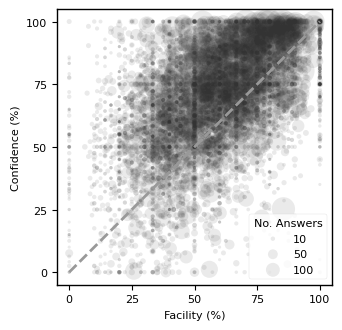

In [42]:
set_style()

fig, ax = plt.subplots(1, 1, figsize=(width_inches_one_column, width_inches_one_column), constrained_layout=True)

x = students["Facility"]
y = students["MeanConfidence"]
s = students["AnswersCount"]

r, p = stats.spearmanr(x, y)
n = len(x)
df = n - 2

ax.scatter(x, y, s=s, alpha=0.1, edgecolors='none')
ax.set_xlabel("Facility (%)")
ax.set_ylabel("Confidence (%)")

ax.set_xticks(facility_values)
ax.set_xticklabels(facility_values)

ax.set_yticks(confidence_values)
ax.set_yticklabels(confidence_values)

ax.set(aspect=1.0)

print(f"Student confidence versus facility {apaStyleCombined(r, p, df, 'rs')}")

ax.plot([0,100], [0,100], color="C2", linestyle='--', linewidth=2)

l1 = ax.scatter([],[], s=10, edgecolors='none', alpha=0.1, color="C0")
l2 = ax.scatter([],[], s=50, edgecolors='none', alpha=0.1, color="C0")
l3 = ax.scatter([],[], s=100, edgecolors='none', alpha=0.1, color="C0")

labels = ["10", "50", "100"]

leg = ax.legend([l1, l2, l3], labels, title='No. Answers')
      
#export_fig(fig, "./images/Fig2")

#### Table 5 The percentage of correct answers by confidence

In [43]:
def my_agg(x):
    names = {
        "AnswersCount": x["IsCorrect"].count(),
        "CorrectCount": x["IsCorrect"].eq(1).sum(),
        "CorrectPercentageMean": round((100 * np.mean(x["IsCorrect"])), 1),
        "CorrectPercentageStd": round((100 * np.std(x["IsCorrect"])), 1)}

    return pd.Series(names, index=["AnswersCount", "CorrectCount", "CorrectPercentageMean", "CorrectPercentageStd"])

answers.groupby("Confidence").apply(my_agg)

,AnswersCount,CorrectCount,CorrectPercentageMean,CorrectPercentageStd
Confidence,,,,
0,20694.0,6773.0,32.7,46.9
25,11915.0,4273.0,35.9,48.0
50,36021.0,16326.0,45.3,49.8
75,51722.0,33282.0,64.3,47.9
100,99474.0,73028.0,73.4,44.2


#### Figure 3 Students' mean confidence on questions that they answered correctly versus their mean confidence on questions that they answered incorrectly

In [44]:
minumum_answers = 50
minumum_correct_and_incorrect_answers = 5

In [45]:
students_411 = students.query("AnswersCount > @minumum_answers")
students_411 = students_411.query("CorrectCount > @minumum_correct_and_incorrect_answers")
students_411 = students_411.query("IncorrectCount > @minumum_correct_and_incorrect_answers")

In [46]:
print(f"Number of answers:\t{sum(students_411['AnswersCount'])}")
print(f"Number of students:\t{len(students_411)}")

Number of answers:	115437
Number of students:	1033


 (rs(1031) = .889, p < .001)


C:\tools\Anaconda3\envs\dqasc\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


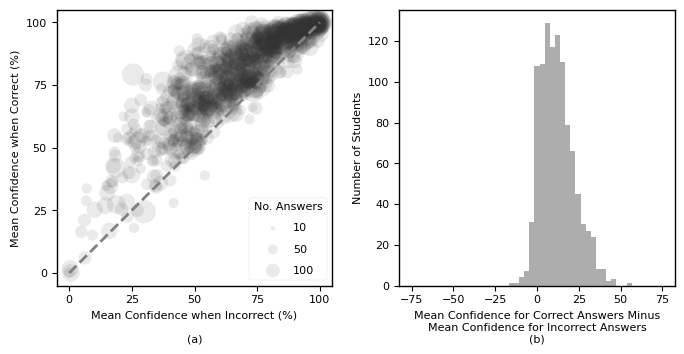

In [47]:
set_style()

conf_dualplot(
    students_411["MeanConfidenceIncorrectAnswers"], 
    students_411["MeanConfidenceCorrectAnswers"],
    students_411["AnswersCount"],
    "",#"Confidence when correct versus\nincorrect for users",
    "Mean Confidence when Incorrect (%)\n\n(a)",
    "Mean Confidence when Correct (%)",
    students_411["ConfidenceDifference"],
    "Mean Confidence for Correct Answers Minus\nMean Confidence for Incorrect Answers\n(b)",
    "Number of Students",
    "",#"Number of students by\ndifference in confidence",
    0.1,
    "./images/Fig3",
    (width_inches_full_page, 0.5*width_inches_full_page))

In [48]:
z, p = stats.wilcoxon(students_411["ConfidenceDifference"])

apaStyleStatistic(z, format="%.0f")

correct_median = students_411["MeanConfidenceCorrectAnswers"].median()
incorrect_median = students_411["MeanConfidenceIncorrectAnswers"].median()

rank_biserial_correlation = wilcoxon_signed_matched_pairs_rank_biserial_correlation(students_411["MeanConfidenceIncorrectAnswers"], students_411["MeanConfidenceCorrectAnswers"])

print(f"A Wilcoxon signed-rank test indicated that, on average, students were more confident on questions which they got correct (Mdn = {correct_median:.1f}) than on those they got incorrect (Mdn = {incorrect_median:.1f}, {apaStyleStatistic(z, format='%.1f')}, rs = {rank_biserial_correlation.rbc:.3f}, {apaStylePValue(p)}).")

A Wilcoxon signed-rank test indicated that, on average, students were more confident on questions which they got correct (Mdn = 82.8) than on those they got incorrect (Mdn = 68.8, Z = 11255.0, rs = 0.956, p < .001).


In [49]:
answers_0 = answers.query("Confidence == 0")["IsCorrect"]
answers_25 = answers.query("Confidence == 25")["IsCorrect"]
answers_50 = answers.query("Confidence == 50")["IsCorrect"]
answers_75 = answers.query("Confidence == 75")["IsCorrect"]
answers_100 = answers.query("Confidence == 100")["IsCorrect"]

s, p = stats.kruskal(answers_0, answers_25, answers_50, answers_75, answers_100)

print(f"A Kruskal-Wallis test found a difference in the number of correct attempts by answers with different confidence (H(4) = {s:.1f}, {apaStylePValue(p)}).")

A Kruskal-Wallis test found a difference in the number of correct attempts by answers with different confidence (H(4) = 20487.1, p < .001).


In [50]:
questions_411 = questions.query("AnswersCount > @minumum_answers")
questions_411 = questions_411.query("CorrectCount > @minumum_correct_and_incorrect_answers")
questions_411 = questions_411.query("IncorrectCount > @minumum_correct_and_incorrect_answers")

In [51]:
print(f"Number of answers:\t{sum(questions_411['AnswersCount'])}")
print(f"Number of students:\t{len(questions_411)}")

Number of answers:	110283
Number of students:	1139


#### Figure 4 Scatterplot of each question's mean confidence by students who were correct against the mean confidence by students who were incorrect

 (rs(1137) = .477, p < .001)


C:\tools\Anaconda3\envs\dqasc\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


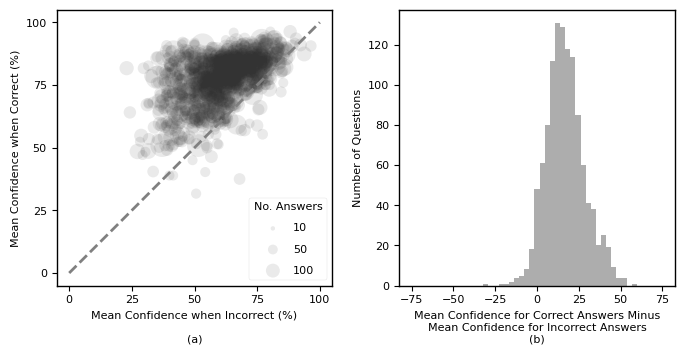

In [52]:
set_style()

conf_dualplot(
    questions_411["MeanConfidenceIncorrectAnswers"], 
    questions_411["MeanConfidenceCorrectAnswers"],
    questions_411["AnswersCount"],
    "",#"Confidence when correct versus\nincorrect for users",
    "Mean Confidence when Incorrect (%)\n\n(a)",
    "Mean Confidence when Correct (%)",
    questions_411["ConfidenceDifference"],
    "Mean Confidence for Correct Answers Minus\nMean Confidence for Incorrect Answers\n(b)",
    "Number of Questions",
    "",#"Number of students by\ndifference in confidence",
    0.1,
    "./images/Fig4",
    (width_inches_full_page, 0.5*width_inches_full_page))

In [53]:
x = students_411["StdConfidence"]
y = questions_411["StdConfidence"]

u, p = stats.mannwhitneyu(x, y, alternative="less")

mdn1 = x.median()
mdn2 = y.median()

us = apaStyleStatistic(u, name = "U", format = "%.1f")
ps = apaStylePValue(p)

mdn1, mdn2, us, ps

print(f"A Mann-Whitney U test indicated that the standard deviation of the confidence was greater for questions (Mdn = {mdn2:.1f}) than for students (Mdn = {mdn1:.1f}, {us}, {ps}).")

A Mann-Whitney U test indicated that the standard deviation of the confidence was greater for questions (Mdn = 30.8) than for students (Mdn = 22.2, U = 284839.5, p < .001).


### 4.1.2 Age

In [54]:
students_age_7_10 = students_2019_to_2020[students_2019_to_2020["age_group_sept_2019"] == "7-10"]
students_age_11_13 = students_2019_to_2020[students_2019_to_2020["age_group_sept_2019"] == "11-13"]
students_age_14_16 = students_2019_to_2020[students_2019_to_2020["age_group_sept_2019"] == "14-16"]

#### Table 6 The percentage of correct answers by confidence

In [55]:
students_describe(students_age_7_10)

,mean,std,Median
AnswersCount,38.6,57.8,18.0
Facility,66.3,21.9,69.2
MeanConfidence,78.8,20.0,83.3


In [56]:
students_describe(students_age_11_13)

,mean,std,Median
AnswersCount,32.8,42.5,17.0
Facility,56.3,21.2,57.1
MeanConfidence,67.8,21.7,70.5


In [57]:
students_describe(students_age_14_16)

,mean,std,Median
AnswersCount,25.8,40.0,11.0
Facility,57.7,23.3,58.8
MeanConfidence,65.6,22.6,67.5


In [58]:
students_kruskal([students_age_7_10, students_age_11_13, students_age_14_16], col="AnswersCount")

The Kruskal-Wallis test statistic is H(2) = 129.2, p < .001.


In [59]:
students_kruskal([students_age_7_10, students_age_11_13, students_age_14_16], col="Facility")

The Kruskal-Wallis test statistic is H(2) = 104.0, p < .001.


In [60]:
students_kruskal([students_age_7_10, students_age_11_13, students_age_14_16], col="MeanConfidence")

The Kruskal-Wallis test statistic is H(2) = 172.2, p < .001.


#### Figure 6 Confidence against facility by key stage, with facility split into decades

In [61]:
students_2019_to_2020["Group"] = ((students_2019_to_2020["Facility"] - 1) // 10).astype("int")
students_2019_to_2020["Group"] = students_2019_to_2020["Group"].clip(lower=0)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2_14-16 v.s. 2_7-10: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.120e+02
3_14-16 v.s. 3_7-10: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.505e-03 U_stat=2.544e+03
4_14-16 v.s. 4_7-10: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.949e-03 U_stat=3.928e+03
5_14-16 v.s. 5_7-10: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.738e-07 U_stat=4.016e+03
6_14-16 v.s. 6_7-10: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.571e-03 U_stat=7.078e+03
7_14-16 v.s. 7_7-10: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.469e-03 U_stat=8.025e+03
1_14-16 v.s. 1_7-10: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.831e-01 U_stat=2.675e+02
0_1

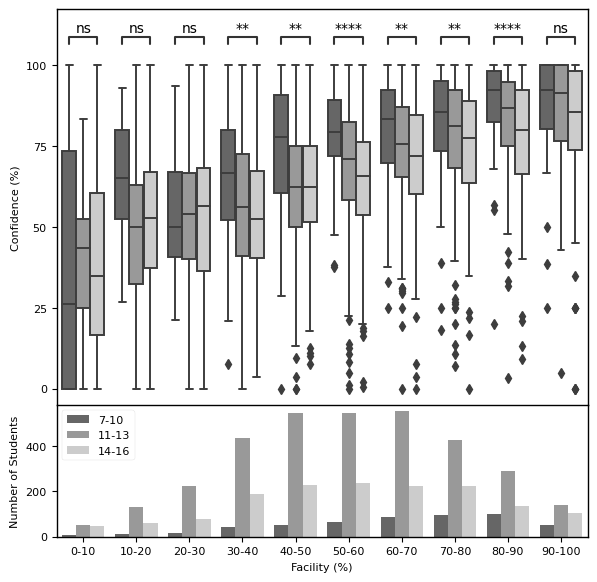

In [62]:
set_style()

fig, axes = plt.subplots(2, 1, figsize=(width_inches_full_page, width_inches_full_page), 
                         gridspec_kw={'height_ratios': [3, 1]})

ax1 = axes[0]

pal = {"7-10": "C1", "11-13": "C2", "14-16": "C3"}

box_pairs=[
    ((0, "7-10"), (0, "14-16")),
    ((1, "7-10"), (1, "14-16")),
    ((2, "7-10"), (2, "14-16")),
    ((3, "7-10"), (3, "14-16")),
    ((4, "7-10"), (4, "14-16")),
    ((5, "7-10"), (5, "14-16")),
    ((6, "7-10"), (6, "14-16")),
    ((7, "7-10"), (7, "14-16")),
    ((8, "7-10"), (8, "14-16")),
    ((9, "7-10"), (9, "14-16"))
    ]

p = sns.boxplot(x="Group", y="MeanConfidence",
            hue="age_group_sept_2019", 
            data=students_2019_to_2020,
            ax=ax1,
            hue_order = ["7-10", "11-13", "14-16"],
            palette=pal)

p.legend_.remove()

ax1.set_ylabel("Confidence (%)")

ax1.set_yticks(confidence_values)
ax1.set_yticklabels(confidence_values)

ax1.set_xlabel('') 
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.spines['bottom'].set_visible(False)

test_results = add_stat_annotation(ax1, data=students_2019_to_2020, 
                                   x="Group", 
                                   y="MeanConfidence", 
                                   hue="age_group_sept_2019", 
                                   box_pairs=box_pairs,
                                   test='Mann-Whitney', loc='inside', verbose=2)

ax2 = plt.subplot(212, sharex = ax1)

sns.countplot(x="Group", hue="age_group_sept_2019", data=students_2019_to_2020, ax=ax2,
            hue_order = ["7-10", "11-13", "14-16"], 
            palette=pal)

ax2.set_xlabel(f"Facility (%)")
ax2.set_ylabel("Number of Students")

ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*10:.0f}-{x*10+10:.0f}'))

ax2.legend(loc='upper left')

plt.subplots_adjust(hspace=.0)

export_fig(fig, "./images/Fig6");

#### Mediation analysis for age on difficulty

In [63]:
import statsmodels.stats.mediation as mediation
import statsmodels.formula.api as smf

In [64]:
# Mediation analysis takes a while so commented out and saved

# outcome_model = smf.ols(formula="MeanConfidence~Facility+AgeSept2018+IsMale+IsAdvantaged", data=students_41_scaled)
# mediator_model = smf.ols(formula="Facility~AgeSept2018", data=students_41_scaled)
# med = mediation.Mediation(outcome_model, mediator_model, "AgeSept2018", "Facility").fit()
# med.summary().to_pickle("output/mediation_age_by_facility.pkl")


In [65]:
med_summary = pd.read_pickle("output/mediation_age_by_facility.pkl")
med_summary.loc[["Total effect", "ACME (average)", "ADE (average)", "Prop. mediated (average)"]].round(3)

,Estimate,Lower CI bound,Upper CI bound,P-value
Total effect,-0.144,-0.171,-0.115,0.000
ACME (average),-0.027,-0.046,-0.008,0.008
ADE (average),-0.117,-0.136,-0.097,0.000
Prop. mediated (average),0.187,0.062,0.294,0.008


### 4.1.3 Gender

In [66]:
students_boy = students[students["Gender"]=="male"]
students_girl = students[students["Gender"]=="female"]

#### Table 7 Mean confidence and facility by gender

In [67]:
students_describe(students_boy)

,mean,std,Median
AnswersCount,30.1,43.2,15.0
Facility,57.5,22.3,58.3
MeanConfidence,71.1,21.7,74.0


In [68]:
students_describe(students_girl)

,mean,std,Median
AnswersCount,30.2,42.1,15.0
Facility,58.2,21.8,59.1
MeanConfidence,65.4,22.0,67.9


In [69]:
students_mann_whitney(students_boy, students_girl, "AnswersCount")

The Mann-Whitney test statistic is U = 6568697.0, p = .296. The medians are 15.0 and 15.0.


In [70]:
students_mann_whitney(students_boy, students_girl, "Facility")

The Mann-Whitney test statistic is U = 6559851.0, p = .253. The medians are 58.3 and 59.1.


In [71]:
students_mann_whitney(students_boy, students_girl, "MeanConfidence")

The Mann-Whitney test statistic is U = 7696906.0, p < .001. The medians are 74.0 and 67.9.


#### Figure 7 Confidence against facility by gender, with facility split into decades 

In [72]:
students["Group"] = ((students["Facility"] - 1) // 10).astype("int")
students["Group"] = students["Group"].clip(lower=0)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_female v.s. 9_male: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.449e-02 U_stat=1.967e+04
8_female v.s. 8_male: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.525e-05 U_stat=4.653e+04
1_female v.s. 1_male: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.868e-02 U_stat=9.365e+03
0_female v.s. 0_male: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.416e-02 U_stat=1.036e+03
2_female v.s. 2_male: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.316e-02 U_stat=2.162e+04
3_female v.s. 3_male: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.547e-04 U_stat=8.710e+04
4_female v.s. 4_male: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.573e-06 U_stat=1.201e

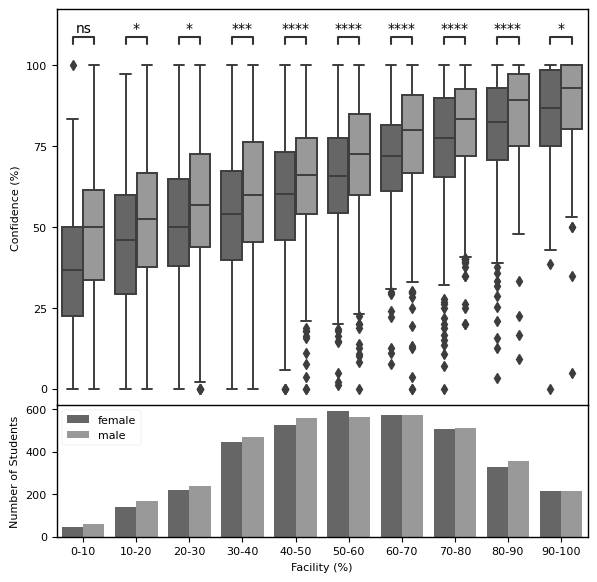

In [73]:
set_style()

fig, axes = plt.subplots(2, 1, figsize=(width_inches_full_page, width_inches_full_page), 
                         gridspec_kw={'height_ratios': [3, 1]})

ax1 = axes[0]

pal = {"female": "C1", "male": "C2"}

box_pairs=[
    ((0, "female"), (0, "male")),
    ((1, "female"), (1, "male")),
    ((2, "female"), (2, "male")),
    ((3, "female"), (3, "male")),
    ((4, "female"), (4, "male")),
    ((5, "female"), (5, "male")),
    ((6, "female"), (6, "male")),
    ((7, "female"), (7, "male")),
    ((8, "female"), (8, "male")),
    ((9, "female"), (9, "male"))
    ]

p = sns.boxplot(x="Group", y="MeanConfidence",
            hue="Gender", 
            data=students,
            ax=ax1,
            hue_order = ["female", "male"],
            palette=pal)

p.legend_.remove()

ax1.set_ylabel("Confidence (%)")

ax1.set_yticks(confidence_values)
ax1.set_yticklabels(confidence_values)

ax1.set_xlabel('') 
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.spines['bottom'].set_visible(False)

test_results = add_stat_annotation(ax1, data=students, 
                                   x="Group", 
                                   y="MeanConfidence", 
                                   hue="Gender", 
                                   box_pairs=box_pairs,
                                   test='Mann-Whitney', loc='inside', verbose=2)

ax2 = plt.subplot(212, sharex = ax1)

sns.countplot(x="Group", hue="Gender", data=students, ax=ax2,
            hue_order = ["female", "male"], 
            palette=pal)

ax2.set_xlabel(f"Facility (%)")
ax2.set_ylabel("Number of Students")

ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*10:.0f}-{x*10+10:.0f}'))

ax2.legend(loc='upper left')

plt.subplots_adjust(hspace=.0)

#export_fig(fig, "./images/Fig7");

#### 4.1.4 Advantage

In [74]:
# Mediation analysis takes a while so commented out and saved

# outcome_model = smf.ols(formula="MeanConfidence~Facility+AgeSept2018+IsMale+IsAdvantaged", data=students_41_scaled)
# mediator_model = smf.ols(formula="Facility~AgeSept2018+IsMale+IsAdvantaged", data=students_41_scaled)
# med = mediation.Mediation(outcome_model, mediator_model, "IsAdvantaged", "Facility").fit()
# med.summary().to_pickle("output/mediation_advantage_by_facility.pkl")

In [75]:
med_summary = pd.read_pickle("output/mediation_advantage_by_facility.pkl")
med_summary.loc[["Total effect", "ACME (average)", "ADE (average)", "Prop. mediated (average)"]].round(3)

,Estimate,Lower CI bound,Upper CI bound,P-value
Total effect,0.248,0.188,0.307,0.0
ACME (average),0.166,0.136,0.197,0.0
ADE (average),0.082,0.030,0.128,0.0
Prop. mediated (average),0.670,0.550,0.844,0.0


In [76]:
students_advantaged = students[students["IsAdvantaged"] == True]
students_disadvantaged = students[students["IsAdvantaged"] == False]

#### Table 8 Mean confidence and facility by disadvantage

In [77]:
students_describe(students_advantaged)

,mean,std,Median
AnswersCount,31.4,44.7,15.0
Facility,59.4,21.8,60.0
MeanConfidence,69.5,21.5,71.9


In [78]:
students_describe(students_disadvantaged)

,mean,std,Median
AnswersCount,25.1,33.3,13.0
Facility,51.9,22.1,50.0
MeanConfidence,64.0,23.6,66.3


In [79]:
students_mann_whitney(students_disadvantaged, students_advantaged, "AnswersCount")

The Mann-Whitney test statistic is U = 4055896.5, p < .001. The medians are 13.0 and 15.0.


In [80]:
_, _, _, _, _, rbc = mann_whitney_rank_biserial_correlation(students_advantaged["AnswersCount"], students_disadvantaged["AnswersCount"])
print(f"The Mann-Whitney Rank Biserial Correlation is {rbc:.3f}.")

The Mann-Whitney Rank Biserial Correlation is -0.086.


In [81]:
students_mann_whitney(students_disadvantaged, students_advantaged, "Facility")

The Mann-Whitney test statistic is U = 3553918.5, p < .001. The medians are 50.0 and 60.0.


In [82]:
_, _, _, _, _, rbc = mann_whitney_rank_biserial_correlation(students_advantaged["Facility"], students_disadvantaged["Facility"])
print(f"The Mann-Whitney Rank Biserial Correlation is {rbc:.3f}.")

The Mann-Whitney Rank Biserial Correlation is -0.199.


In [83]:
students_mann_whitney(students_disadvantaged, students_advantaged, "MeanConfidence")

The Mann-Whitney test statistic is U = 3849712.5, p < .001. The medians are 66.3 and 71.9.


In [84]:
_, _, _, _, _, rbc = mann_whitney_rank_biserial_correlation(students_advantaged["MeanConfidence"], students_disadvantaged["MeanConfidence"])
print(f"The Mann-Whitney Rank Biserial Correlation is {rbc:.3f}.")

The Mann-Whitney Rank Biserial Correlation is -0.133.


In [85]:
students["Advantage"] = np.where(students["IsAdvantaged"] == 1, "advantaged", "disadvantaged")

#### Figure 9 Confidence against facility by disadvantage, with facility split into decades

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

9_advantaged v.s. 9_disadvantaged: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.183e+04
8_advantaged v.s. 8_disadvantaged: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.560e+04
1_advantaged v.s. 1_disadvantaged: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.556e+03
0_advantaged v.s. 0_disadvantaged: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.409e+03
2_advantaged v.s. 2_disadvantaged: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.646e-01 U_stat=2.417e+04
3_advantaged v.s. 3_disadvantaged: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.874e+04
4_advantaged v.s. 4_disadvantaged: Man

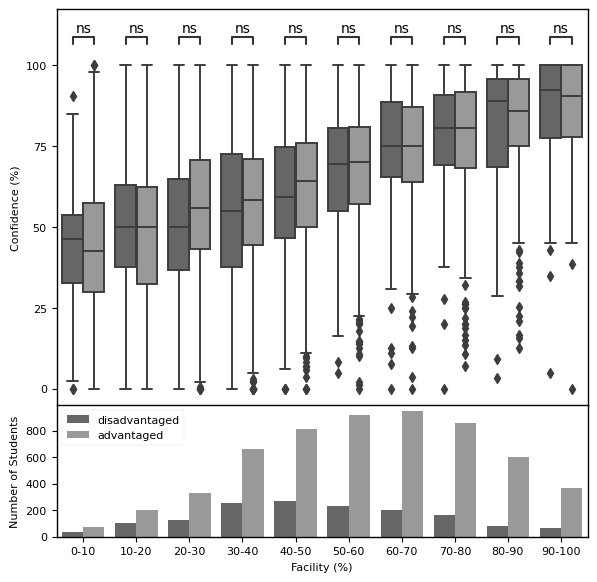

In [86]:
set_style()

fig, axes = plt.subplots(2, 1, figsize=(width_inches_full_page, width_inches_full_page), 
                         gridspec_kw={'height_ratios': [3, 1]})

ax1 = axes[0]

pal = {"disadvantaged": "C1", "advantaged": "C2"}

box_pairs=[
    ((0, "disadvantaged"), (0, "advantaged")),
    ((1, "disadvantaged"), (1, "advantaged")),
    ((2, "disadvantaged"), (2, "advantaged")),
    ((3, "disadvantaged"), (3, "advantaged")),
    ((4, "disadvantaged"), (4, "advantaged")),
    ((5, "disadvantaged"), (5, "advantaged")),
    ((6, "disadvantaged"), (6, "advantaged")),
    ((7, "disadvantaged"), (7, "advantaged")),
    ((8, "disadvantaged"), (8, "advantaged")),
    ((9, "disadvantaged"), (9, "advantaged"))
    ]

p = sns.boxplot(x="Group", y="MeanConfidence",
            hue="Advantage", 
            data=students,
            ax=ax1,
            hue_order = ["disadvantaged", "advantaged"],
            palette=pal)

p.legend_.remove()

ax1.set_ylabel("Confidence (%)")

ax1.set_yticks(confidence_values)
ax1.set_yticklabels(confidence_values)

ax1.set_xlabel('') 
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.spines['bottom'].set_visible(False)

test_results = add_stat_annotation(ax1, data=students, 
                                   x="Group", 
                                   y="MeanConfidence", 
                                   hue="Advantage", 
                                   box_pairs=box_pairs,
                                   test='Mann-Whitney', loc='inside', verbose=2)

ax2 = plt.subplot(212, sharex = ax1)

sns.countplot(x="Group", hue="Advantage", data=students, ax=ax2,
            hue_order = ["disadvantaged", "advantaged"], 
            palette=pal)

ax2.set_xlabel(f"Facility (%)")
ax2.set_ylabel("Number of Students")

ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*10:.0f}-{x*10+10:.0f}'))

ax2.legend(loc='upper left')

plt.subplots_adjust(hspace=.0)

#export_fig(fig, "./images/Fig9");

## 4.2 Is there evidence for the hypercorrection effect in students' responses on quiz B (administered 3 weeks later)?

In [87]:
mistakes = answers[answers["IsCorrect"]==False].copy()

In [88]:
print(f"Number of quiz A mistakes:\t\t\t{len(mistakes)}")
print(f"Number of students who made quiz A mistakes:\t{mistakes['UserId'].nunique()}")

Number of quiz A mistakes:			86144
Number of students who made quiz A mistakes:	7002


#### Table 9 Students attempting an analogous question, following an incorrect answer, and the proportion of these which were correct

In [89]:
def my_agg(x):
    names = {
        "AnswersCount": x["AnswerId"].count(),
        "QuizBAnswersCount": x["QuizBAnswerId"].notnull().sum(),
        "QuizBAnswersMean": round((100 * np.mean(x["QuizBAnswerId"].notnull())), 1),
        "QuizBAnswersStd": round((100 * np.std(x["QuizBAnswerId"].notnull())), 1),
        "CorrectQuizBAnswersCount": x["QuizBIsCorrect"].eq(1).sum(),
        "QuizBCorrectPercentageMean": round(100 * np.mean(x["QuizBIsCorrect"]), 1),
        "QuizBCorrectPercentageStd": round(100 * np.std(x["QuizBIsCorrect"]), 1)}

    return pd.Series(names, index=["AnswersCount", "QuizBAnswersCount", "QuizBAnswersMean", "QuizBAnswersStd", "CorrectQuizBAnswersCount", "QuizBCorrectPercentageMean", "QuizBCorrectPercentageStd"])

mistakes_by_confidence = mistakes.groupby("Confidence").apply(my_agg)
mistakes_by_confidence

,AnswersCount,QuizBAnswersCount,QuizBAnswersMean,QuizBAnswersStd,CorrectQuizBAnswersCount,QuizBCorrectPercentageMean,QuizBCorrectPercentageStd
Confidence,,,,,,,
0,13921.0,6809.0,48.9,50.0,2656.0,39.0,48.8
25,7642.0,3766.0,49.3,50.0,1471.0,39.1,48.8
50,19695.0,9866.0,50.1,50.0,3968.0,40.2,49.0
75,18440.0,9726.0,52.7,49.9,4535.0,46.6,49.9
100,26446.0,14357.0,54.3,49.8,7255.0,50.5,50.0


In [90]:
mistakes_conf_0 = mistakes[mistakes["Confidence"] == 0]
mistakes_conf_25 = mistakes[mistakes["Confidence"] == 25]
mistakes_conf_50 = mistakes[mistakes["Confidence"] == 50]
mistakes_conf_75 = mistakes[mistakes["Confidence"] == 75]
mistakes_conf_100 = mistakes[mistakes["Confidence"] == 100]

In [91]:
h, p = stats.kruskal(*[group["QuizBAnswerId"].notnull().values for name, group in mistakes.groupby("Confidence")])

print(f"The Kruskal-Wallis test statistic is H(4) = {h:.1f}, {apaStylePValue(p)}")

The Kruskal-Wallis test statistic is H(4) = 160.6, p < .001


In [92]:
h, p = stats.kruskal(*[group["QuizBIsCorrect"].values for name, group in mistakes[mistakes["QuizBAnswerId"].notnull()].groupby("Confidence")])

print(f"The Kruskal-Wallis test statistic is H(4) = {h:.1f}, {apaStylePValue(p)}")

The Kruskal-Wallis test statistic is H(4) = 430.1, p < .001


If you see a RuntimeWarning when running Kruskal-Wallis you need to [fix the stats.py file](https://github.com/scipy/scipy/issues/7759). 

#### Figure 10 Students attempting a similar question 3 weeks later (quiz B), following an incorrect answer, and the proportion of these which were correct

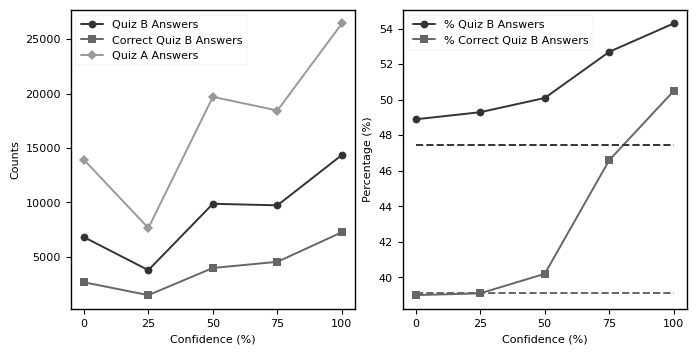

In [93]:
set_style(markers=True)

fig, ax = plt.subplots(1, 2, figsize=(width_inches_full_page, 0.5*width_inches_full_page), constrained_layout=True)

ax[0].plot(mistakes_by_confidence[["QuizBAnswersCount", "CorrectQuizBAnswersCount", "AnswersCount"]])
ax[0].legend(["Quiz B Answers", "Correct Quiz B Answers", "Quiz A Answers"])

ax[0].set_xticks(confidence_values)
ax[0].set_xticklabels(confidence_values)

ax[0].set_xlabel("Confidence (%)")
ax[0].set_ylabel("Counts")

ax[1].plot(mistakes_by_confidence[["QuizBAnswersMean", "QuizBCorrectPercentageMean"]])

ax[1].hlines(y=answers_without_confidence["IncorrectQuizAQuizBAnswersPercentage"], xmin=0, xmax=100, color="C0", linestyle='--')
ax[1].hlines(y=answers_without_confidence["IncorrectQuizACorrectQuizBAnswersPercentage"], xmin=0, xmax=100, color="C1", linestyle='--')

ax[1].legend(["% Quiz B Answers", "% Correct Quiz B Answers"])

ax[1].set_xticks(confidence_values)
ax[1].set_xticklabels(confidence_values)

ax[1].set_xlabel("Confidence (%)")
ax[1].set_ylabel("Percentage (%)")

export_fig(fig, "./images/Fig10")

#### Footnote


In [94]:
student_confidence = answers.groupby("UserId")["Confidence"].agg([ "std", "nunique" ])

In [95]:
x = mistakes[["UserId", "Confidence"]].copy()
x["confidence_0_50_100"] = x["Confidence"].isin([0,50,100])
y = x.groupby("UserId")["confidence_0_50_100"].agg([ "mean" ])
print(f"For incorrect answers, {100 * sum(y['mean'] > 0.9) / len(y):.0f}% of students used 0, 50, 100 only for at least 90% of their answers")

For incorrect answers, 29% of students used 0, 50, 100 only for at least 90% of their answers


In [96]:
x = answers[["UserId", "Confidence"]].copy()
x["confidence_0_50_100"] = x["Confidence"].isin([0,50,100])
y = x.groupby("UserId")["confidence_0_50_100"].agg([ "mean" ])
print(f"For all answers, {100 * sum(y['mean'] > 0.9) / len(y):.0f}% of students used 0, 50, 100 only for at least 90% of their answers")

For all answers, 23% of students used 0, 50, 100 only for at least 90% of their answers


#### Figure 11 Student confidence versus facility in quiz A and quiz B

To examine metacognition we restrict our dataset to those answers for which the student answered both the quiz A and quiz B questions with confidence.

In [97]:
answers_metacognition = answers_raw[answers_raw["QuizBConfidence"].notnull()].copy()

In [98]:
len(answers_metacognition)

83758

In [99]:
students_metacognition = answers_metacognition.groupby("UserId").agg( 
    AnswersCount = ("AnswerId", "count"),    
    MeanConfidence = ("Confidence", "mean"),
    CorrectCount = ("IsCorrect", lambda x: sum(x == 1)),
    QuizBMeanConfidence = ("QuizBConfidence", "mean"),
    QuizBCorrectCount = ("QuizBIsCorrect", lambda x: sum(x == 1))
)

students_metacognition = students_metacognition[students_metacognition["AnswersCount"] >= 10]

students_metacognition["Facility"] = 100 * students_metacognition["CorrectCount"] / students_metacognition["AnswersCount"]
students_metacognition["QuizBFacility"] = 100 * students_metacognition["QuizBCorrectCount"] / students_metacognition["AnswersCount"]

students_metacognition["MeanConfidence - Facility"] = \
    students_metacognition["MeanConfidence"] - students_metacognition["Facility"]

students_metacognition["QuizBMeanConfidence - QuizBFacility"] = \
    students_metacognition["QuizBMeanConfidence"] - students_metacognition["QuizBFacility"]

Student confidence versus facility (rs(1654) = .509, p < .001)
Student confidence versus facility (rs(1654) = .502, p < .001)


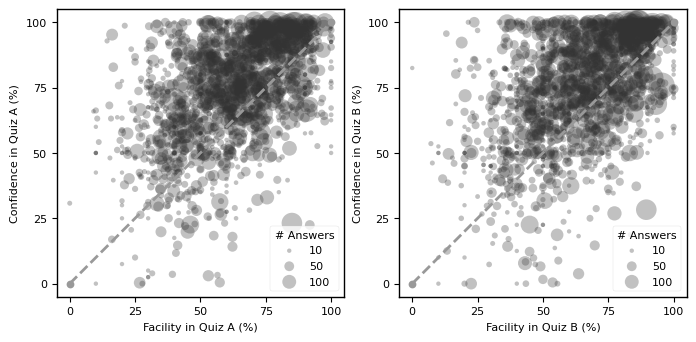

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(width_inches_full_page, 0.5*width_inches_full_page), constrained_layout=True)

ax = axes[0]

x = students_metacognition["Facility"]
y = students_metacognition["MeanConfidence"]
s = students_metacognition["AnswersCount"]

r, p = stats.spearmanr(x, y)
n = len(x)
df = n - 2

ax.scatter(x, y, s=s, alpha=0.3, edgecolors='none')
ax.set_xlabel("Facility in Quiz A (%)")
ax.set_ylabel("Confidence in Quiz A (%)")

ax.set_xticks(facility_values)
ax.set_xticklabels(facility_values)

ax.set_yticks(confidence_values)
ax.set_yticklabels(confidence_values)

print(f"Student confidence versus facility {apaStyleCombined(r, p, df, 'rs')}")
ax.plot([0,100],[0,100], linestyle='--', linewidth=2, color="C2")

ax.set(aspect=1.0)

l1 = ax.scatter([],[], s=10, edgecolors='none', alpha=0.3, color="C0")
l2 = ax.scatter([],[], s=50, edgecolors='none', alpha=0.3, color="C0")
l3 = ax.scatter([],[], s=100, edgecolors='none', alpha=0.3, color="C0")

labels = ["10", "50", "100"]

leg = ax.legend([l1, l2, l3], labels, title='# Answers')

ax = axes[1]

x = students_metacognition["QuizBFacility"]
y = students_metacognition["QuizBMeanConfidence"]
s = students_metacognition["AnswersCount"]

r, p = stats.spearmanr(x, y)
n = len(x)
df = n - 2

ax.scatter(x, y, s=s, alpha=0.3, edgecolors='none')
ax.set_xlabel("Facility in Quiz B (%)")
ax.set_ylabel("Confidence in Quiz B (%)")

ax.set_xticks(facility_values)
ax.set_xticklabels(facility_values)

ax.set_yticks(confidence_values)
ax.set_yticklabels(confidence_values)

print(f"Student confidence versus facility {apaStyleCombined(r, p, df, 'rs')}")
ax.plot([0,100],[0,100], linestyle='--', linewidth=2, color="C2")

ax.set(aspect=1.0)

l1 = ax.scatter([],[], s=10, edgecolors='none', alpha=0.3, color="C0")
l2 = ax.scatter([],[], s=50, edgecolors='none', alpha=0.3, color="C0")
l3 = ax.scatter([],[], s=100, edgecolors='none', alpha=0.3, color="C0")

labels = ["10", "50", "100"]

leg = ax.legend([l1, l2, l3], labels, title='# Answers')
      
export_fig(fig, "./images/Fig11")

#### Table 10 Distribution of data for logistic regression

In [101]:
mistakes_inc_quizb = mistakes[mistakes["QuizBAnswerId"].notnull()]

In [102]:
print(f"Number of mistakes with quiz B answers:\t{len(mistakes_inc_quizb)}")
print(f"Number of students with quiz B answers:\t{mistakes_inc_quizb['UserId'].nunique()}")

Number of mistakes with quiz B answers:	44524
Number of students with quiz B answers:	3838


In [103]:
def my_agg(x):
    names = {
        "N": x["AnswerId"].count(),
        "FacilityMean": round(np.mean(x["Facility"]), 1),
        "FacilityStd": round(np.std(x["Facility"]), 1),
        "ConfidenceMean": round(np.mean(x["Confidence"]), 1),
        "ConfidenceStd": round(np.std(x["Confidence"]), 1),
        "AgeMean": round(np.mean(x["AgeSept2018"]), 1),
        "AgeStd": round(np.std(x["AgeSept2018"]), 1),
        "Advantaged": sum(x["IsAdvantaged"] == 1),
        "Disadvantaged": sum(x["IsAdvantaged"] == 0),
        "Female": sum(x["Gender"] == "female"),
        "Male": sum(x["Gender"] == "male")}

    return pd.Series(names, index=["N", "FacilityMean", "FacilityStd", "ConfidenceMean", "ConfidenceStd", "AgeMean", "AgeStd", "Advantaged", "Disadvantaged", "Female", "Male"])

mistakes_inc_quizb.groupby("QuizBIsCorrect").apply(my_agg)

,N,FacilityMean,FacilityStd,ConfidenceMean,ConfidenceStd,AgeMean,AgeStd,Advantaged,Disadvantaged,Female,Male
QuizBIsCorrect,,,,,,,,,,,
0.0,24639.0,50.4,16.6,58.9,35.4,11.4,1.8,19348.0,5291.0,12552.0,12087.0
1.0,19885.0,57.6,17.2,65.4,34.6,11.2,1.9,16233.0,3652.0,10288.0,9597.0


In [104]:
mistakes_inc_quizb[["Facility", "Confidence", "AgeSept2018"]].describe().T[["count", "mean", "std"]].round(1)

,count,mean,std
Facility,44524.0,53.6,17.2
Confidence,44524.0,61.8,35.2
AgeSept2018,44524.0,11.3,1.8


In [105]:
mistakes_inc_quizb.groupby("IsAdvantaged").size()

IsAdvantaged
0     8943
1    35581
dtype: int64

In [106]:
mistakes_inc_quizb.groupby("Gender").size()

Gender
female    22840
male      21684
dtype: int64

In [107]:
d = mistakes_inc_quizb[["QuizBIsCorrect", "Facility", "Confidence", "AgeSept2018", "IsAdvantaged", "Gender"]].copy()

d["IsMale"] = np.where(d["Gender"] == "male", 1, 0).astype("int64")
d["intercept"] = 1.0

x = d[["Facility", "Confidence", "AgeSept2018", "IsAdvantaged", "IsMale", "intercept"]]
y = d["QuizBIsCorrect"]

logit = sm.Logit(y, x)

result=logit.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.664312
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         QuizBIsCorrect   No. Observations:                44524
Model:                          Logit   Df Residuals:                    44518
Method:                           MLE   Df Model:                            5
Date:                Sun, 13 Feb 2022   Pseudo R-squ.:                 0.03364
Time:                        08:37:56   Log-Likelihood:                -29578.
converged:                       True   LL-Null:                       -30607.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Facility         0.0235      0.001     38.614      0.000       0.022       0.025
Confidence       0.0028

In [108]:
result.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
                     chi2        P>chi2  df constraint
Facility      1491.053862  0.000000e+00              1
Confidence      97.741124  4.768161e-23              1
AgeSept2018     12.310778  4.503503e-04              1
IsAdvantaged     2.628114  1.049864e-01              1
IsMale           5.516575  1.883710e-02              1
intercept      372.902973  4.366501e-83              1

In [109]:
# Odd ratio for each coefficient

pow(math.e, result.params)

Facility        1.023782
Confidence      1.002850
AgeSept2018     0.981328
IsAdvantaged    1.041029
IsMale          0.954955
intercept       0.232752
dtype: float64

In [110]:
pow(math.e, result.conf_int())

,0,1
Facility,1.022561,1.025004
Confidence,1.002284,1.003416
AgeSept2018,0.971051,0.991715
IsAdvantaged,0.991631,1.092888
IsMale,0.918923,0.992400
intercept,0.200741,0.269868


In [111]:
R = np.eye(len(result.params))[:-1]
result.wald_test(R)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[1936.39819455]], p-value=0.0, df_denom=5>

In [112]:
# Likelihood Ratio Statistic (versus the null model) equals -2 * (result.llnull - result.llf)

result.llr, result.llr_pvalue, result.df_model

(2059.176890710951, 0.0, 5.0)

In [113]:
import verhulst.stats as vs
import verhulst.plots as vp

# Fudge for deprecated function which vs relies on
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [114]:
y_true = y.values
y_pred = result.predict(x).values

In [115]:
vs.hosmer_lemeshow_test(y_true, y_pred, n_groups=10)

HosmerLemeshowTest(C_hat=39329.989344379195, df=8, p=0.0)

## Appendix A: Comparability of quiz A and quiz B questions

In [116]:
print(f"There are {len(answers[answers['QuizBQuestionId'].notnull()][['QuestionId','QuizBQuestionId']].drop_duplicates())} question pairs in the dataset.")

There are 6370 question pairs in the dataset.


In [117]:
questions_a_and_b = pd.read_csv("input/questions_a_and_b.csv", 
    dtype = { 
        "QuizAQuestionId": "int64",
        "QuizAAnswersCount": "int64",
        "QuizACorrectAnswersCount": "int64",
        "QuizBQuestionId": "int64",
        "QuizBAnswersCount": "int64",
        "QuizBCorrectAnswersCount": "int64",
        "QuizBNotAAnswersCount": "float64",
        "QuizBNotACorrectAnswersCount": "float64"
    })

In [118]:
questions_a_and_b = questions_a_and_b[questions_a_and_b["QuizAAnswersCount"] > 20]
questions_a_and_b = questions_a_and_b[questions_a_and_b["QuizBNotAAnswersCount"] > 20]

print(f"There are {len(questions_a_and_b)} question pairs with at least 20 answers.")

There are 6232 question pairs with at least 20 answers.


In [119]:
questions_a_and_b["QuizAPercentage"] =  100 * questions_a_and_b["QuizACorrectAnswersCount"] / questions_a_and_b["QuizAAnswersCount"]
questions_a_and_b["QuizBNotAPercentage"] =  100 * questions_a_and_b["QuizBNotACorrectAnswersCount"] / questions_a_and_b["QuizBNotAAnswersCount"]

In [120]:
questions_a_and_b["Calibration"] = questions_a_and_b["QuizAPercentage"] - questions_a_and_b["QuizBNotAPercentage"]

C:\tools\Anaconda3\envs\dqasc\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


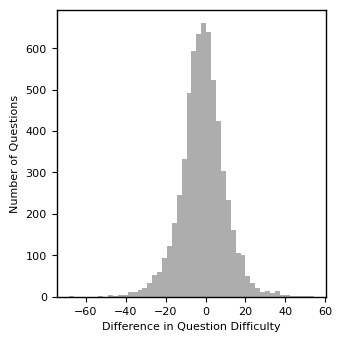

In [121]:
set_style()

fig, axes = plt.subplots(1, 1, figsize=(width_inches_one_column, width_inches_one_column), constrained_layout=True)

ax = axes

sns.distplot(questions_a_and_b["Calibration"], norm_hist=False, kde=False)#, fit=stats.t, kde=False)

ax.set_xlabel(f"Difference in Question Difficulty")
ax.set_ylabel("Number of Questions")
ax.set_title(f"Number of questions by calibration")

export_fig(fig, "./images/Fig12")

In [122]:
d = questions_a_and_b["Calibration"]

w, p = stats.wilcoxon(d - d.median())

d.median(), w, p

print(f"The median is {d.median():.2f}. The Wilcoxon signed-rank test statistic is {w:.1f}, {apaStylePValue(p)}.")

The median is -1.38. The Wilcoxon signed-rank test statistic is 9709954.5, p = .994.
